# CHAPTER 09. 문장(시계열수치)입력 다중클래스분류 모델 레시피

In [9]:
# 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, \
                         Conv1D, GlobalMaxPooling1D, MaxPooling1D

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
import matplotlib.pyplot as plt

## 데이터셋 준비
* 뉴스와이어(뉴스 보도 자료) 데이터셋을 이용한다. 이 데이터셋은 총 11,228개의 샘플로 구성되어 있고, 라벨은 46개 주제로 지정되어 0에서 45의 값을 가진다.
* 데이터셋은 이미 정수로 인코딩되어 있으며, 정수값은 단어의 빈도수를 나타낸다.

In [10]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000)

In [11]:
print(len(x_train))
print(len(x_test))

8982
2246


In [12]:
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [13]:
print(y_train[0])

3


In [15]:
# 훈련셋 8,892개 중 다시 7,000개를 훈련셋으로, 나머지를 검증셋으로 분리한다.
x_val = x_train[7000:]
y_val = y_train[7000:]
x_train = x_train[:7000]
y_train = y_train[:7000]

각 샘플의 길이가 달라서 모델의 입력으로 사용하기 위해 케라스에서 제공되는 전처리 함수인 sequence의 pad_sequences() 함수를 사용한다.
* **pad_sequences() 함수 역할**
    * 문장의 길이를 maxlen 인자로 맞춘다.
    * (num_samples, num_timesteps) 으로 2차원의 numpy 배열로 만들어준다.

In [16]:
print(len(x_train[0]))

87


In [17]:
x_train = sequence.pad_sequences(x_train, maxlen=120)
x_val = sequence.pad_sequences(x_val, maxlen=120)
x_test = sequence.pad_sequences(x_test, maxlen=120)

In [20]:
print(len(x_train[0]))
print(x_train[0])

120
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    1    2    2    8   43   10  447    5   25
  207  270    5 3095  111   16  369  186   90   67    7   89    5   19
  102    6   19  124   15   90   67   84   22  482   26    7   48    4
   49    8  864   39  209  154    6  151    6   83   11   15   22  155
   11   15    7   48    9 4579 1005  504    6  258    6  272   11   15
   22  134   44   11   15   16    8  197 1245   90   67   52   29  209
   30   32  132    6  109   15   17   12]


In [22]:
# one-hot 인코딩
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [24]:
print(len(y_train[0]))
print(y_train[0])

46
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<br>

---

<br>

# 모델 준비
## 다층퍼셉트론 신경망 모델

![image](https://user-images.githubusercontent.com/43431081/81909489-a4140600-9605-11ea-9945-5bd2deedfabc.png)

* 임베딩 레이어는 한 단어를 128 벡터로 인코딩한다.
    * 예시
      ```python
        # 문장 토큰화와 단어 토큰화
        text=[['Hope', 'to', 'see', 'you', 'soon'],['Nice', 'to', 'see', 'you', 'again']]

        # 각 단어에 대한 정수 인코딩
        text=[[0, 1, 2, 3, 4],[5, 1, 2, 3, 6]]

        # 위 데이터가 아래의 임베딩 층의 입력이 된다.
        Embedding(7, 2, input_length=5)
        # 7은 단어의 개수. 즉, 단어 집합(vocabulary)의 크기이다.
        # 2는 임베딩한 후의 벡터의 크기이다.
        # 5는 각 입력 시퀀스의 길이. 즉, input_length이다.

        # 각 정수는 아래의 테이블의 인덱스로 사용되며 Embeddig()은 각 단어에 대해 임베딩 벡터를 리턴한다.
        +------------+------------+
        |   index    | embedding  |
        +------------+------------+
        |     0      | [1.2, 3.1] |
        |     1      | [0.1, 4.2] |
        |     2      | [1.0, 3.1] |
        |     3      | [0.3, 2.1] |
        |     4      | [2.2, 1.4] |
        |     5      | [0.7, 1.7] |
        |     6      | [4.1, 2.0] |
        +------------+------------+
        # 위의 표는 임베딩 벡터가 된 결과를 예로서 정리한 것이고 Embedding()의 출력인 3D 텐서를 보여주는 것이 아님.
        ```

In [21]:
model = Sequential()
model.add(Embedding(15000, 128, input_length=120))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(46, activation='softmax'))  # 다중분류이므로 softmax 활성화 함수를 사용한다.

In [31]:
# 딥러닝 모델 가시화
def visualize(model):
    return SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

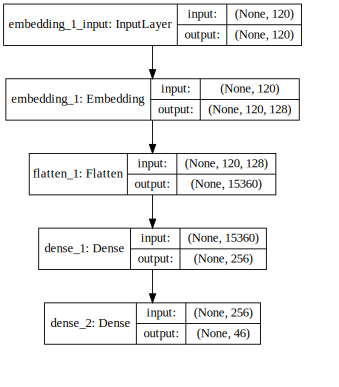

In [32]:
visualize(model)

In [25]:
def learning(model):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))
    return hist

In [26]:
def review(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 3.0])

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylim([0.0, 1.0])

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuracy')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [27]:
def evaluate(model):
    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
    print('## evaluation loss and metrics ##')
    print(loss_and_metrics)

In [28]:
hist = learning(model)

/Users/sangminlee/keras-tutorial/venv/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7000 samples, validate on 1982 samples
Epoch 1/10
7000/7000 [==============================] - 8s 1ms/step - loss: 1.8984 - accuracy: 0.5277 - val_loss: 1.4385 - val_accuracy: 0.6609
Epoch 2/10
7000/7000 [==============================] - 8s 1ms/step - loss: 0.8049 - accuracy: 0.8221 - val_loss: 1.2863 - val_accuracy: 0.7069
Epoch 3/10
7000/7000 [==============================] - 8s 1ms/step - loss: 0.2667 - accuracy: 0.9531 - val_loss: 1.3767 - val_accuracy: 0.6887
Epoch 4/10
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1807 - accuracy: 0.9616 - val_loss: 1.3158 - val_accuracy: 0.7059
Epoch 5/10
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1552 - accuracy: 0.9609 - val_loss: 1.3509 - val_accuracy: 0.7048
Epoch 6/10
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1281 - accuracy: 0.9647 - val_loss: 1.3690 - val_accuracy: 0.7023
Epoch 7/10
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1133 - acc

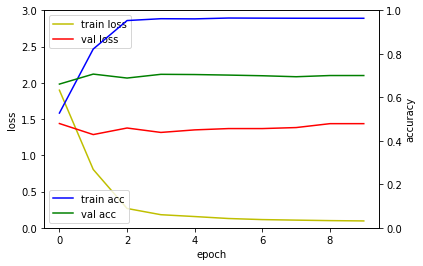

In [29]:
review(hist)

In [30]:
evaluate(model)

2246/2246 [==============================] - 0s 62us/step
## evaluation loss and metrics ##
[1.5131350438295468, 0.6825467348098755]


<br>

---

<br>

# 모델 준비
## 순환 신경망 모델

![image](https://user-images.githubusercontent.com/43431081/81909505-aa09e700-9605-11ea-8737-6ee806b3c706.png)

* 임베딩 레이어에서 반환되는 120개 벡터를 LSTM의 타임스텝으로 입력하는 모델이다. 
* LSTM의 input_dim은 임베딩 레이어에서 인코딩된 벡터 크기인 128이다.

In [33]:
cycleModel = Sequential()
cycleModel.add(Embedding(15000, 128))
cycleModel.add(LSTM(128))
cycleModel.add(Dense(46, activation='softmax'))

In [34]:
cycleHist = learning(cycleModel)

/Users/sangminlee/keras-tutorial/venv/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7000 samples, validate on 1982 samples
Epoch 1/10
7000/7000 [==============================] - 15s 2ms/step - loss: 2.5170 - accuracy: 0.3601 - val_loss: 2.1379 - val_accuracy: 0.4768
Epoch 2/10
7000/7000 [==============================] - 16s 2ms/step - loss: 1.9940 - accuracy: 0.4884 - val_loss: 1.8469 - val_accuracy: 0.5020
Epoch 3/10
7000/7000 [==============================] - 17s 2ms/step - loss: 1.7056 - accuracy: 0.5573 - val_loss: 1.6935 - val_accuracy: 0.5610
Epoch 4/10
7000/7000 [==============================] - 17s 2ms/step - loss: 1.5289 - accuracy: 0.6080 - val_loss: 1.5113 - val_accuracy: 0.6211
Epoch 5/10
7000/7000 [==============================] - 16s 2ms/step - loss: 1.2593 - accuracy: 0.6753 - val_loss: 1.4243 - val_accuracy: 0.6463
Epoch 6/10
7000/7000 [==============================] - 16s 2ms/step - loss: 1.0092 - accuracy: 0.7349 - val_loss: 1.3633 - val_accuracy: 0.6640
Epoch 7/10
7000/7000 [==============================] - 15s 2ms/step - loss: 0.814

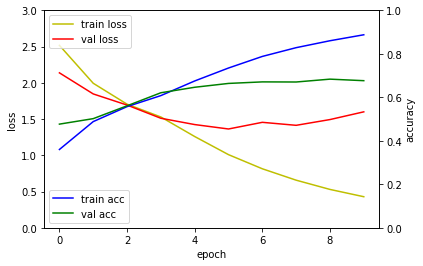

In [35]:
review(cycleHist)

In [36]:
evaluate(cycleModel)

2246/2246 [==============================] - 1s 483us/step
## evaluation loss and metrics ##
[1.7084700143029408, 0.6651825308799744]


<br>

---

<br>

# 모델 준비
## 컨볼루션 신경망 모델

![image](https://user-images.githubusercontent.com/43431081/81909803-1258c880-9606-11ea-8d13-d650ca0b1350.png)

* 임베딩 레이어에서 반환되는 120개 벡터를 컨볼루션 필터를 적용한 모델이다.

In [41]:
convModel = Sequential()
convModel.add(Embedding(15000, 128, input_length=120))
convModel.add(Dropout(0.2))
convModel.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
convModel.add(GlobalMaxPooling1D())
convModel.add(Dense(128, activation='relu'))
convModel.add(Dropout(0.2))
convModel.add(Dense(46, activation='softmax'))

In [42]:
convHist = learning(convModel)

Train on 7000 samples, validate on 1982 samples
Epoch 1/10
7000/7000 [==============================] - 6s 916us/step - loss: 2.3173 - accuracy: 0.4399 - val_loss: 1.7898 - val_accuracy: 0.5182
Epoch 2/10
7000/7000 [==============================] - 6s 912us/step - loss: 1.6003 - accuracy: 0.6147 - val_loss: 1.3803 - val_accuracy: 0.6796
Epoch 3/10
7000/7000 [==============================] - 6s 890us/step - loss: 1.2728 - accuracy: 0.6949 - val_loss: 1.2249 - val_accuracy: 0.7099
Epoch 4/10
7000/7000 [==============================] - 6s 912us/step - loss: 1.0253 - accuracy: 0.7544 - val_loss: 1.1296 - val_accuracy: 0.7306
Epoch 5/10
7000/7000 [==============================] - 6s 900us/step - loss: 0.8146 - accuracy: 0.8023 - val_loss: 1.0931 - val_accuracy: 0.7477
Epoch 6/10
7000/7000 [==============================] - 6s 899us/step - loss: 0.6170 - accuracy: 0.8427 - val_loss: 1.1025 - val_accuracy: 0.7533
Epoch 7/10
7000/7000 [==============================] - 6s 891us/step - loss

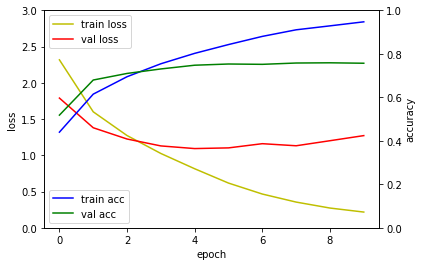

In [43]:
review(convHist)

In [44]:
evaluate(convModel)

2246/2246 [==============================] - 0s 115us/step
## evaluation loss and metrics ##
[1.3294882086484643, 0.7471059560775757]


<br>

---

<br>

# 모델 준비
## 순환 컨볼루션 신경망 모델

![image](https://user-images.githubusercontent.com/43431081/81909813-15ec4f80-9606-11ea-8164-16ba97039b0b.png)

* 컨볼루션 레이어에서 나온 특징벡터들을 맥스풀링을 통해 1/4로 줄여준 다음 LSTM의 입력으로 넣어주는 모델이다.

In [46]:
cycleConvModel = Sequential()
cycleConvModel.add(Embedding(15000, 128, input_length=120))
cycleConvModel.add(Dropout(0.2))
cycleConvModel.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
cycleConvModel.add(MaxPooling1D(pool_size=4))
cycleConvModel.add(LSTM(128))
cycleConvModel.add(Dense(46, activation='softmax'))

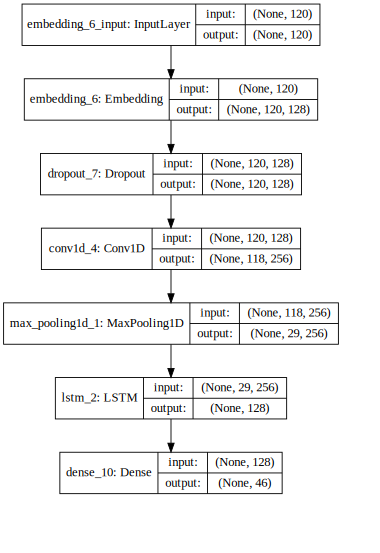

In [47]:
visualize(cycleConvModel)

In [48]:
cycleConvHist = learning(cycleConvModel)

/Users/sangminlee/keras-tutorial/venv/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7000 samples, validate on 1982 samples
Epoch 1/10
7000/7000 [==============================] - 11s 2ms/step - loss: 2.1463 - accuracy: 0.4587 - val_loss: 1.6915 - val_accuracy: 0.5671
Epoch 2/10
7000/7000 [==============================] - 11s 2ms/step - loss: 1.5805 - accuracy: 0.5926 - val_loss: 1.4624 - val_accuracy: 0.6433
Epoch 3/10
7000/7000 [==============================] - 11s 2ms/step - loss: 1.2736 - accuracy: 0.6821 - val_loss: 1.3634 - val_accuracy: 0.6690
Epoch 4/10
7000/7000 [==============================] - 11s 2ms/step - loss: 1.0176 - accuracy: 0.7447 - val_loss: 1.2719 - val_accuracy: 0.6978
Epoch 5/10
7000/7000 [==============================] - 11s 2ms/step - loss: 0.8140 - accuracy: 0.7950 - val_loss: 1.2596 - val_accuracy: 0.7154
Epoch 6/10
7000/7000 [==============================] - 11s 2ms/step - loss: 0.6488 - accuracy: 0.8363 - val_loss: 1.2779 - val_accuracy: 0.7149
Epoch 7/10
7000/7000 [==============================] - 10s 1ms/step - loss: 0.522

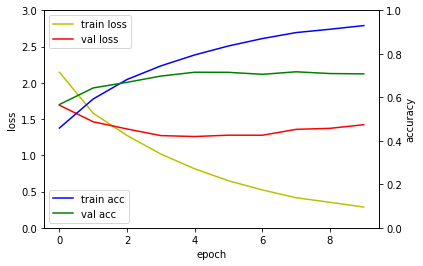

In [49]:
review(cycleConvHist)

In [50]:
evaluate(cycleConvModel)

2246/2246 [==============================] - 1s 373us/step
## evaluation loss and metrics ##
[1.5581829324961771, 0.6807658076286316]


<br>

---

<br>

# 학습결과 비교

=== 다층퍼셉트론 신경망 ===


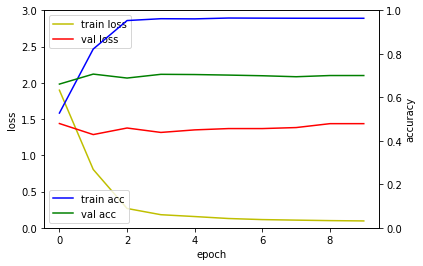


=== 순환 신경망 ===


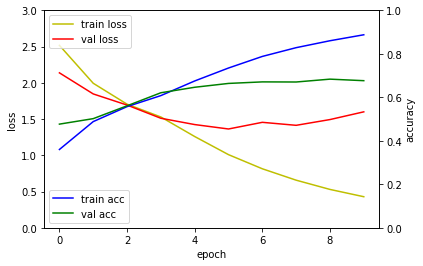


=== 컨볼루션 신경망 ===


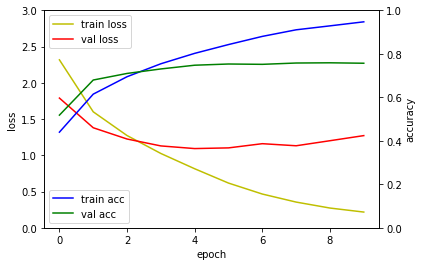


=== 순환 컨볼루션 신경망 ===


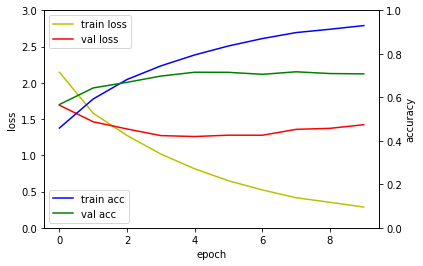

In [52]:
print('=== 다층퍼셉트론 신경망 ===')
review(hist)
print('\n=== 순환 신경망 ===')
review(cycleHist)
print('\n=== 컨볼루션 신경망 ===')
review(convHist)
print('\n=== 순환 컨볼루션 신경망 ===')
review(cycleConvHist)